In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tmg_hmc import TMGSampler

# Define Kernels

In [2]:
class SQExponentialKernel:
    def __init__(self, length_scale=1.0, variance=1.0):
        self.length_scale = length_scale
        self.variance = variance

    def __call__(self, x1, x2, cov_type='x_x'):
        if cov_type == 'x_x':
            return self.cov_x_x(x1, x2)
        elif cov_type == 'x_dx':
            return self.cov_x_dx(x1, x2)
        elif cov_type == 'dx_x':
            return self.cov_dx_x(x1, x2)
        elif cov_type == 'dx_dx':
            return self.cov_dx_dx(x1, x2)
        elif cov_type == 'x_d2x':
            return self.cov_x_d2x(x1, x2)
        elif cov_type == 'd2x_x':
            return self.cov_d2x_x(x1, x2)
        elif cov_type == 'd2x_d2x':
            return self.cov_d2x_d2x(x1, x2)
        else:
            raise ValueError(f"Unknown covariance type: {cov_type}")
    
    def cov_x_x(self, x1, x2):
        """Covariance between function values: k(x1, x2)
        
        Args:
            x1: shape (n1,) or (n1, 1)
            x2: shape (n2,) or (n2, 1)
        Returns:
            shape (n1, n2)
        """
        x1 = np.atleast_1d(x1).flatten()
        x2 = np.atleast_1d(x2).flatten()
        
        sqdist = (x1[:, None] - x2[None, :])**2
        return self.variance * np.exp(-0.5 / self.length_scale**2 * sqdist)
    
    def cov_x_dx(self, x1, x2):
        """Covariance between function and first derivative: ∂k/∂x2
        
        Formula: (x1 - x2) / ℓ² * k(x1, x2)
        
        Returns:
            shape (n1, n2)
        """
        x1 = np.atleast_1d(x1).flatten()
        x2 = np.atleast_1d(x2).flatten()
        
        K = self.cov_x_x(x1, x2)
        diff = x1[:, None] - x2[None, :]
        
        return (diff / self.length_scale**2) * K
    
    def cov_dx_x(self, x1, x2):
        """Covariance between first derivative and function: -∂k/∂x1
        
        Formula: -(x1 - x2) / ℓ² * k(x1, x2)
        
        Returns:
            shape (n1, n2)
        """
        return -self.cov_x_dx(x1, x2)
    
    def cov_dx_dx(self, x1, x2):
        """Covariance between first derivatives: ∂²k/(∂x1 ∂x2)
        
        Formula: k(x1, x2) * [1/ℓ² - (x1 - x2)²/ℓ⁴]
        
        Returns:
            shape (n1, n2)
        """
        x1 = np.atleast_1d(x1).flatten()
        x2 = np.atleast_1d(x2).flatten()
        
        K = self.cov_x_x(x1, x2)
        diff = x1[:, None] - x2[None, :]
        
        return K * ((1 / self.length_scale**2) - (diff**2 / self.length_scale**4))
    
    def cov_x_d2x(self, x1, x2):
        """Covariance between function and second derivative: ∂²k/∂x2²
        
        Formula: k(x1, x2) * [(x1 - x2)²/ℓ⁴ - 1/ℓ²]
        
        Returns:
            shape (n1, n2)
        """
        x1 = np.atleast_1d(x1).flatten()
        x2 = np.atleast_1d(x2).flatten()
        
        K = self.cov_x_x(x1, x2)
        diff = x1[:, None] - x2[None, :]
        
        return K * ((diff**2 / self.length_scale**4) - (1 / self.length_scale**2))
    
    def cov_d2x_x(self, x1, x2):
        """Covariance between second derivative and function: ∂²k/∂x1²
        
        Formula: k(x1, x2) * [(x1 - x2)²/ℓ⁴ - 1/ℓ²]
        
        Returns:
            shape (n1, n2)
        """
        return self.cov_x_d2x(x1, x2)
    
    def cov_d2x_d2x(self, x1, x2):
        """Covariance between second derivatives: ∂⁴k/(∂x1² ∂x2²)
        
        Formula: k(x1, x2) * [3/ℓ⁴ - 6(x1-x2)²/ℓ⁶ + (x1-x2)⁴/ℓ⁸]
        
        Returns:
            shape (n1, n2)
        """
        x1 = np.atleast_1d(x1).flatten()
        x2 = np.atleast_1d(x2).flatten()
        
        K = self.cov_x_x(x1, x2)
        diff = x1[:, None] - x2[None, :]
        diff2 = diff**2
        diff4 = diff**4
        
        l2 = self.length_scale**2
        l4 = self.length_scale**4
        l6 = self.length_scale**6
        l8 = self.length_scale**8
        
        return K * (3/l4 - 6*diff2/l6 + diff4/l8)

# Bounded GP

In [3]:
n = 100
x = np.linspace(0, 10, n)
kernel = SQExponentialKernel(length_scale=2.0, variance=2.0)
K = kernel(x, x, cov_type='x_x')

sampler = TMGSampler(mu=np.zeros((n,1)), Sigma=K)

upper_bound = 2 
lower_bound = 0
for i in range(n):
    f = np.zeros((n,1))
    f[i] = 1 
    sampler.add_constraint(f=-f, c=upper_bound)
    sampler.add_constraint(f=f, c=-lower_bound)

x0 = np.ones((n,1)) * (upper_bound + lower_bound) / 2
samples = sampler.sample(x0, n_samples=100, burn_in=100)

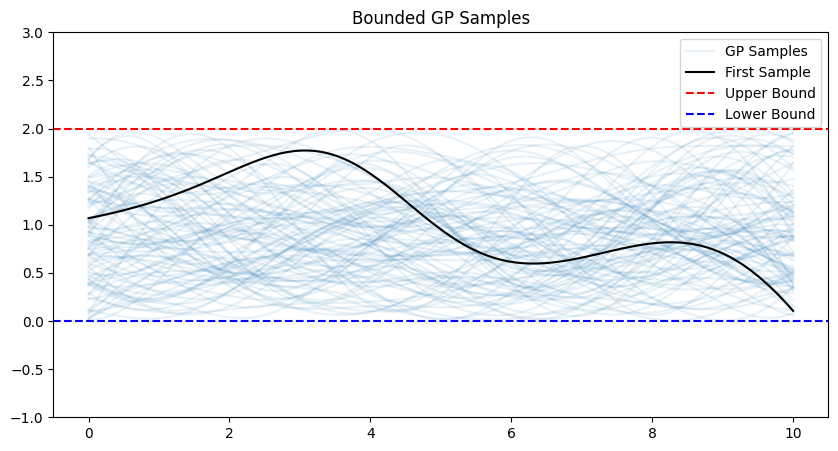

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(x, samples[:-1].T, color='C0', alpha=0.1)
ax.plot(x, samples[-1], color='C0', alpha=0.1, label='GP Samples')
ax.plot(x, samples[0], color='black', label='First Sample')
ax.set_title('Bounded GP Samples')
ax.set_ylim(lower_bound-1, upper_bound+1)
ax.axhline(upper_bound, color='red', linestyle='--', label='Upper Bound')
ax.axhline(lower_bound, color='blue', linestyle='--', label='Lower Bound')
ax.legend()
plt.show()

# Monotone GP

In [5]:
n = 100
x = np.linspace(0, 10, n)
kernel = SQExponentialKernel(length_scale=2.0, variance=2.0)
K = np.block([[kernel(x, x, cov_type='x_x'), kernel(x, x, cov_type='x_dx')],
              [kernel(x, x, cov_type='dx_x'), kernel(x, x, cov_type='dx_dx')]])

sampler = TMGSampler(mu=np.zeros((2*n,1)), Sigma=K)

for i in range(n):
    f = np.zeros((2*n,1))
    f[n + i] = 1 
    sampler.add_constraint(f=f, c=0)

x0 = np.ones((2*n,1))
x0[:n] *= 0.0

samples = sampler.sample(x0, n_samples=100, burn_in=100)

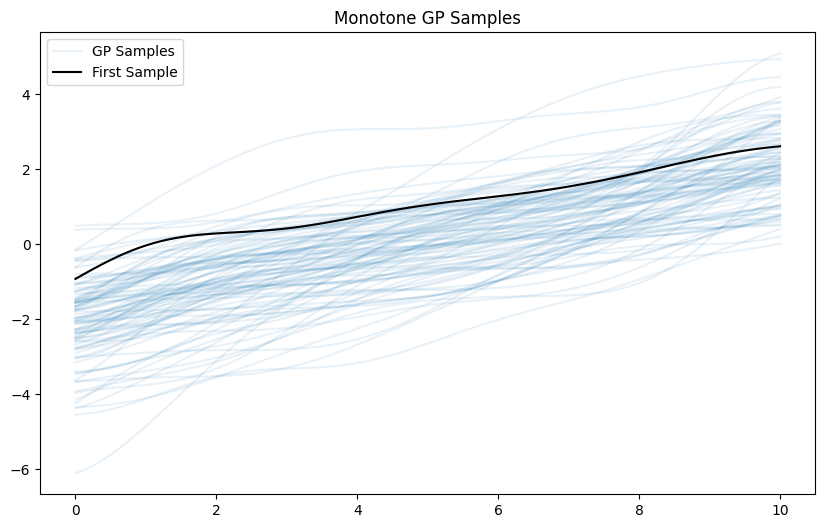

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, samples[:-1,:n].T, color='C0', alpha=0.1)
ax.plot(x, samples[-1,:n], color='C0', alpha=0.1, label='GP Samples')
ax.plot(x, samples[0,:n], color='black', label='First Sample')
ax.set_title('Monotone GP Samples')
ax.legend()
plt.show()

# Convex GP

In [7]:
n = 100
x = np.linspace(0, 10, n)
kernel = SQExponentialKernel(length_scale=2.0, variance=2.0)
K = np.block([[kernel(x, x, cov_type='x_x'), kernel(x, x, cov_type='x_d2x')],
              [kernel(x, x, cov_type='d2x_x'), kernel(x, x, cov_type='d2x_d2x')]])

sampler = TMGSampler(mu=np.zeros((2*n,1)), Sigma=K)

for i in range(n):
    f = np.zeros((2*n,1))
    f[n + i] = 1 
    sampler.add_constraint(f=f, c=0)

x0 = np.ones((2*n,1))
x0[:n] *= 0.0

samples = sampler.sample(x0, n_samples=100, burn_in=100)

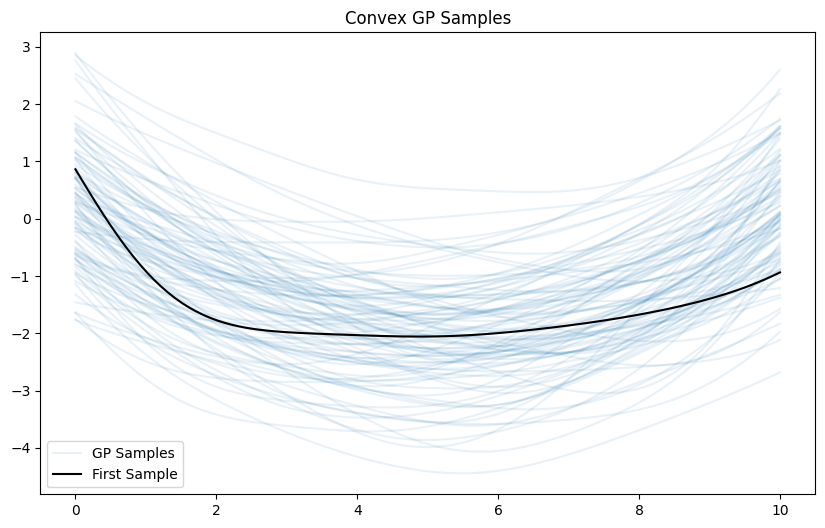

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, samples[:-1,:n].T, color='C0', alpha=0.1)
ax.plot(x, samples[-1,:n], color='C0', alpha=0.1, label='GP Samples')
ax.plot(x, samples[0,:n], color='black', label='First Sample')
ax.set_title('Convex GP Samples')
ax.legend()
plt.show()